# 4 задание

#### Вариант 4. Сравнение GAP и Flatten

**Цель:** Понимание различий между Flatten и Global Average Pooling.

- Спроектируйте сеть с 3 свёрточными слоями, после которых выходной тензор `(batch, 128, 8, 8)`.
- **Условие:** Реализуйте два варианта классификации:
  1. `Flatten → Linear`
  2. `Global Average Pooling → Linear`
- **Эксперимент:** Обучите оба варианта на данных и сравните дисперсию выходных активаций перед финальным слоем.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from matplotlib import pyplot as plt

In [42]:

class ConvNetFlatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) 
        self.fc = nn.Linear(128*8*8, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # (3, 32, 32)   -> (32, 32, 32)
        x = self.pool(x)              # (32, 32, 32)  -> (32, 16,16)
        x = self.relu(self.conv2(x))  # (32, 16, 16)  -> (64, 16, 16)
        x = self.pool(x)              # (64, 16, 16)  -> (64, 8, 8)
        x = self.relu(self.conv3(x))  # (64, 8, 8)    -> (128, 8, 8)
        x = x.view(x.size(0), -1)     # flatten (batch, 128 * 8 * 8)
        pre_fc = x                    # save pred linear law state
        x = self.fc(pre_fc)
        return x, pre_fc


class ConvNetGAP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d((1,1))  # GAP
        self.fc = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # (3, 32, 32)   -> (32, 32, 32)
        x = self.pool(x)              # (32, 32, 32)  -> (32, 16,16)
        x = self.relu(self.conv2(x))  # (32, 16, 16)  -> (64, 16, 16)
        x = self.pool(x)              # (64, 16, 16)  -> (64, 8, 8)
        x = self.relu(self.conv3(x))  # (64, 8, 8)    -> (128, 8, 8)
        x = self.gap(x)               # (batch, 128, 1, 1)
        x = x.view(x.size(0), -1)     # serilixation GAP (barch, 128 * 1 * 1)
        pre_fc = x
        x = self.fc(pre_fc)
        return x, pre_fc



In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_flatten = ConvNetFlatten().to(device)
model_gap = ConvNetGAP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_flat = Adam(model_flatten.parameters(), lr=0.001)
optimizer_gap = Adam(model_gap.parameters(), lr=0.001)

epochs = 5

# train one epoch
def train_one_epoch(model, optimizer, loader):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# var in input model on pre_fc
def evaluate_variance(model, loader):
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            _, pre_fc = model(images)
            var = pre_fc.var(dim=0).mean().item()
            return var

for epoch in range(epochs):
    loss_flat = train_one_epoch(model_flatten, optimizer_flat, train_loader)
    loss_gap = train_one_epoch(model_gap, optimizer_gap, train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Flatten Loss: {loss_flat:.4f} | GAP Loss: {loss_gap:.4f}")

var_flat = evaluate_variance(model_flatten, test_loader)
var_gap = evaluate_variance(model_gap, test_loader)

print(f"Flatten pre_fc variance: {var_flat}")
print(f"GAP pre_fc variance: {var_gap}")


100%|██████████| 782/782 [00:16<00:00, 47.37it/s]


Epoch 1/5 - Flatten Loss: 1.4785 | GAP Loss: 1.8174


100%|██████████| 782/782 [00:16<00:00, 48.07it/s]


Epoch 2/5 - Flatten Loss: 1.0869 | GAP Loss: 1.5115


100%|██████████| 782/782 [00:16<00:00, 47.33it/s]


Epoch 3/5 - Flatten Loss: 0.9232 | GAP Loss: 1.3889


100%|██████████| 782/782 [00:16<00:00, 46.24it/s]


Epoch 4/5 - Flatten Loss: 0.8215 | GAP Loss: 1.2999


100%|██████████| 782/782 [00:15<00:00, 51.14it/s]

Epoch 5/5 - Flatten Loss: 0.7429 | GAP Loss: 1.2231
Flatten pre_fc variance: 0.01866108924150467
GAP pre_fc variance: 0.2688738703727722


Flatten показывает более высокую точность начиная с первой эпохи. 

При Flatten много нейронов (8192), но но у них малая дисперсия. Это может быть связано с тем, что из-за большого количества признаков они сглаживаются, и сеть в итоге более сбалансированная, но менее контрастная.

При GAP меньше нейровнов (128), но каждый из них значительно активнее, то есть сеть фокусируется на более сильных объектах, GAP усредняет все пространственные детали.

In [45]:
model_flatten.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs, _ = model_flatten(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 70.63%


In [46]:
model_gap.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs, _ = model_gap(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 55.73%


Точность также у flatten выше, так как он использует полную информацию, без усреднения

# 5 задание

#### Вариант 5. Контроль градиентов через глубину

**Цель:** Изучение поведения градиентов в глубокой сети.

- Разработайте сеть с **не менее 6 слоев**, которая выводит тензор `(batch, 64, 8, 8)`.
- **Условие:** Слои должны чередоваться между `Conv2d` и `ReLU`, при этом **градиенты первого слоя должны быть меньше градиентов последнего** после одной итерации `backward()` на случайных данных.
- **Эксперимент:** Визуализируйте градиенты по слоям и объясните, почему градиенты убывают или растут.


In [5]:
class DeepConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (batch, 3, 32, 32) -> (batch, 32, 32, 32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)             # (batch, 32, 16, 16) -> (batch, 32, 16, 16)
        self.conv3 = nn.Conv2d(32, 48, 3, padding=1)             # (batch, 32, 16, 16) -> (batch, 48, 16, 16)
        self.pool2 = nn.MaxPool2d(2, 2)                           # (batch, 48, 16, 16) -> (batch, 48, 8, 8)
        
        self.conv4 = nn.Conv2d(48, 48, 3, padding=1)             # (batch, 48, 8, 8)  -> (batch, 48, 8, 8)
        self.conv5 = nn.Conv2d(48, 64, 3, padding=1)             # (batch, 48, 8, 8)  -> (batch, 64, 8, 8)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)             # (batch, 64, 8, 8)  -> (batch, 64, 8, 8)
    
    def forward(self, x):
        x = self.conv1(x)       # (batch, 3, 32, 32) -> (batch, 32, 32, 32)
        x = self.relu(x)
        x = self.pool(x)        # (batch, 32, 32, 32) -> (batch, 32, 16, 16)
        
        x = self.conv2(x)       # (batch, 32, 16, 16)
        x = self.relu(x)
        x = self.conv3(x)       # (batch, 48, 16, 16)
        x = self.relu(x)
        x = self.pool2(x)       # (batch, 48, 16, 16) -> (batch, 48, 8, 8)
        
        x = self.conv4(x)       # (batch, 48, 8, 8)
        x = self.relu(x)
        x = self.conv5(x)       # (batch, 64, 8, 8)
        x = self.relu(x)
        x = self.conv6(x)       # (batch, 64, 8, 8)
        x = self.relu(x)
        
        return x

Layer: conv1.weight, Gradient Norm: 0.001816
Layer: conv2.weight, Gradient Norm: 0.007108
Layer: conv3.weight, Gradient Norm: 0.006731
Layer: conv4.weight, Gradient Norm: 0.009717
Layer: conv5.weight, Gradient Norm: 0.012017
Layer: conv6.weight, Gradient Norm: 0.015117


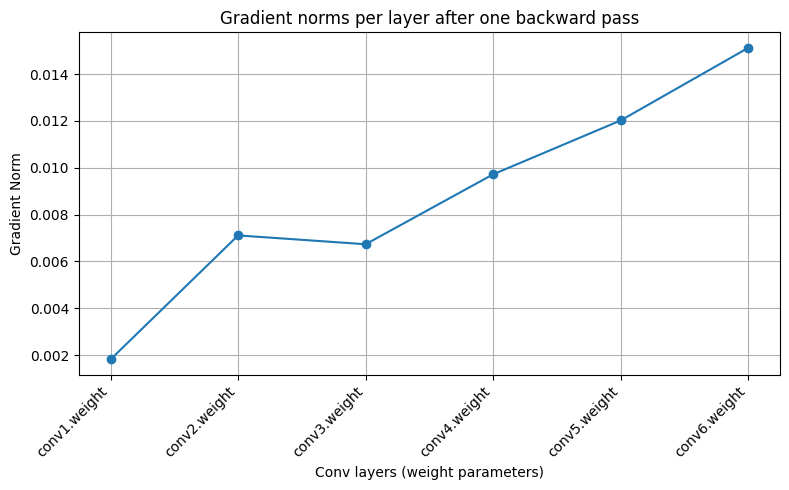

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DeepConvNet().to(device)

# Random batch for test (batch=16, 3, 32, 32)
x = torch.randn(16, 3, 32, 32).to(device)

# Source target: (batch, 8, 8)
target = torch.randint(0, 64, (16, 8, 8)).to(device)

criterion = nn.CrossEntropyLoss()
output = model(x)  # output (16, 64, 8, 8)

output_flat = output.permute(0, 2, 3, 1).reshape(-1, 64)  # (batch*8*8, 64)
target_flat = target.reshape(-1)                          # (batch*8*8)

loss = criterion(output_flat, target_flat)

model.zero_grad()

# will calculate gradients for all weights
loss.backward()

# Save grad norm in Conv
grad_norms = []
for name, param in model.named_parameters():
    if 'weight' in name and param.grad is not None:
        grad_norm = param.grad.norm().item()
        grad_norms.append((name, grad_norm))
        print(f'Layer: {name}, Gradient Norm: {grad_norm:.6f}')

plt.figure(figsize=(8,5))
plt.plot(range(1, len(grad_norms)+1), [g[1] for g in grad_norms], marker='o')
plt.xticks(range(1, len(grad_norms)+1), [g[0] for g in grad_norms], rotation=45, ha='right')
plt.xlabel('Conv layers (weight parameters)')
plt.ylabel('Gradient Norm')
plt.title('Gradient norms per layer after one backward pass')
plt.grid(True)
plt.tight_layout()
plt.show()

После одного шага обратного распространения ошибки были измерены нормы градиентов весов каждого сверточного слоя. Результаты показали, что градиенты первых слоев меньше, чем последних. Это отражает эффект затухания градиентов - обратное распространение ошибок уменьшается при передаче через глубокие слои сети.

Наверное, причинами являются:

- многократное применение производных при обратном проходе (цепное правило),
- нелинейность ReLU, которая обнуляет часть активаций,
- отсутствие нормализации или пропускных связей.

На графике видно монотонное увеличение нормы градиента по мере приближения к выходу сети.